# MRI PLS

Does decoding maps with PCs give more info than with direct PLS?

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

Attaching package: ‘ggh4x’



    geom_pointpath, GeomPointPath




In [4]:
maps = get_maps()

In [5]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSCanonical, PLSRegression

In [7]:
map_decodings = {}
# Get different gene decodings for each map
for m in maps.columns:
    # Get PCR weights (equivalent to correlation coefs except for missing regions)
    X = dm_hcp_ds8.clean_scores().set_index('label') # can optionally use smoother maps here
    Y = maps.loc[X.index, m] # if we also restandardize Y after dropping regions, betas = pearson r
    pcr = LinearRegression().fit(X,Y)
    pcr_weights_ds8 = pd.Series(dm_hcp_3d_ds5.weights.iloc[:,:3] @ pcr.coef_, name='PCR_DS8')

    # Repeat PCR but with DS5 maps
    X = dm_hcp_3d_ds5.clean_scores().set_index('label') # can optionally use smoother maps here
    Y = maps.loc[X.index, m] # if we also restandardize Y after dropping regions, betas = pearson r
    pcr = LinearRegression().fit(X,Y)
    pcr_weights_ds5 = pd.Series(dm_hcp_3d_ds5.weights.iloc[:,:3] @ pcr.coef_, name='PCR_DS5')

    # Get PLS weights from full data
    X = dm_hcp_3d_ds5.expression.join(get_labels_hcp()).set_index('label')
    Y = maps.loc[X.index, m]
    pls = PLSCanonical(n_components=1).fit(X,Y)
    pls_weights = pd.Series(pls.x_weights_.squeeze(), index=X.columns, name='PLS_DS5')
    # match pls sign to pcr
    if sum(pcr_weights_ds8 * pls_weights) < 1:
        pls_weights *= -1
    
    map_decodings[m] = pd.concat([pcr_weights_ds8, pcr_weights_ds5, pls_weights], axis=1)

In [8]:
pd.concat(map_decodings, axis=1).to_csv("../outputs/map_decodings.csv")

In [11]:
pd.concat(map_decodings, axis=1)

T1T2                     thickness                      \
           PCR_DS8   PCR_DS5   PLS_DS5   PCR_DS8   PCR_DS5   PLS_DS5   
A1BG     -0.010263 -0.010213 -0.013035  0.010008  0.009927 -0.014953   
A1BG-AS1 -0.011844 -0.012862 -0.011918  0.007818  0.009712 -0.013004   
AAAS      0.008086  0.008362  0.011026 -0.007388 -0.007638  0.012474   
AAED1    -0.008574 -0.007719 -0.011363  0.009371  0.008617 -0.011322   
AAGAB    -0.011142 -0.010891 -0.009467  0.004941  0.007466 -0.008046   
...            ...       ...       ...       ...       ...       ...   
ZSWIM9   -0.007048 -0.006640 -0.012249  0.006794  0.006668 -0.011480   
ZWINT    -0.007287 -0.007515 -0.008477  0.007696  0.007448 -0.012601   
ZYX       0.010601  0.010362  0.014687 -0.011005 -0.010567  0.016114   
ZZEF1     0.014483  0.014137  0.015826 -0.009741 -0.011522  0.015203   
ZZZ3     -0.006622 -0.006577 -0.009662  0.006907  0.006649 -0.007903   

           G1_fMRI                     PC1_neurosynth  ... hill.evo_remapped  \
           PCR_DS8   PCR_DS5   PLS_DS5        PCR_DS8  ...           PLS_DS5   
A1BG      0.004978  0.004877 -0.010823       0.004124  ...         -0.006731   
A1BG-AS1  0.008789  0.009223 -0.004520       0.007767  ...         -0.014785   
AAAS     -0.004209 -0.004455  0.009795      -0.004334  ...         -0.001695   
AAED1     0.003693  0.002696 -0.006551       0.000555  ...         -0.005344   
AAGAB     0.011555  0.009523 -0.010349       0.001662  ...         -0.018477   
...            ...       ...       ...            ...  ...               ...   
ZSWIM9    0.003756  0.003117 -0.006150       0.001318  ...         -0.014368   
ZWINT     0.002754  0.003231 -0.002034       0.004179  ...         -0.005443   
ZYX      -0.004593 -0.004398  0.015199      -0.003741  ...          0.001440   
ZZEF1    -0.011663 -0.009908  0.021721      -0.003219  ...          0.015398   
ZZZ3      0.002766  0.002804 -0.009267       0.002760  ...         -0.004030   

         hill.dev_remapped                     glasser_CBF            \
                   PCR_DS8   PCR_DS5   PLS_DS5     PCR_DS8   PCR_DS5   
A1BG             -0.000884 -0.001052 -0.010329   -0.005048 -0.006777   
A1BG-AS1         -0.000332  0.002102 -0.003279   -0.006973 -0.005953   
AAAS              0.001380  0.000974  0.005208    0.005093  0.005870   
AAED1             0.001428  0.000002 -0.002972   -0.000983 -0.003803   
AAGAB             0.008738  0.010632  0.016283    0.003387  0.004257   
...                    ...       ...       ...         ...       ...   
ZSWIM9            0.001196  0.000700  0.016769   -0.001269 -0.002817   
ZWINT            -0.002693 -0.002752 -0.008886   -0.005833 -0.007074   
ZYX               0.001059  0.001698  0.002011    0.005037  0.007358   
ZZEF1            -0.006514 -0.007669 -0.011801   -0.000166  0.000382   
ZZZ3             -0.001175 -0.001473 -0.007162   -0.003767 -0.005123   

                       allom                      
           PLS_DS5   PCR_DS8   PCR_DS5   PLS_DS5  
A1BG      0.015991 -0.004375 -0.003345  0.014571  
A1BG-AS1  0.011062  0.000188  0.002249 -0.001920  
AAAS     -0.012897  0.003017  0.001897 -0.007211  
AAED1     0.008369 -0.004259 -0.004222  0.011710  
AAGAB    -0.009340  0.006542  0.006904 -0.013782  
...            ...       ...       ...       ...  
ZSWIM9    0.013610 -0.002275 -0.001995 -0.010218  
ZWINT     0.017349 -0.004611 -0.003531  0.023733  
ZYX      -0.016212  0.005464  0.004552 -0.014523  
ZZEF1    -0.000584 -0.002381 -0.003128  0.003899  
ZZZ3      0.009286 -0.003634 -0.002945  0.008455  

[7973 rows x 30 columns]

In [9]:
correlate(X,Y)

,allom
A1BG,-0.203336
A1BG-AS1,0.026801
AAAS,0.100637
AAED1,-0.163415
AAGAB,0.192335
...,...
ZSWIM9,0.142591
ZWINT,-0.331196
ZYX,0.202668
ZZEF1,-0.054407


In [10]:
pls.x_weights_

array([[ 0.01457075],
       [-0.00192049],
       [-0.00721146],
       ...,
       [-0.01452289],
       [ 0.00389872],
       [ 0.00845508]])

In [290]:
from sklearn.decomposition import FastICA, PCA

In [291]:
pca = PCA(n_components=3).fit(maps)
pca_scores = pca.transform(maps)
pca_weights = pca.components_.T
                       
pca_scores = pd.DataFrame(pca_scores, 
                          columns=['G1','G2','G3'], 
                          index=maps.index) \
            .apply(lambda x: (x-np.mean(x))/np.std(x))

pca_weights = pd.DataFrame(pca_weights,
                          columns=['G1','G2','G3'], 
                          index=maps.columns) 
            # .apply(lambda x: (x-np.mean(x))/np.std(x))

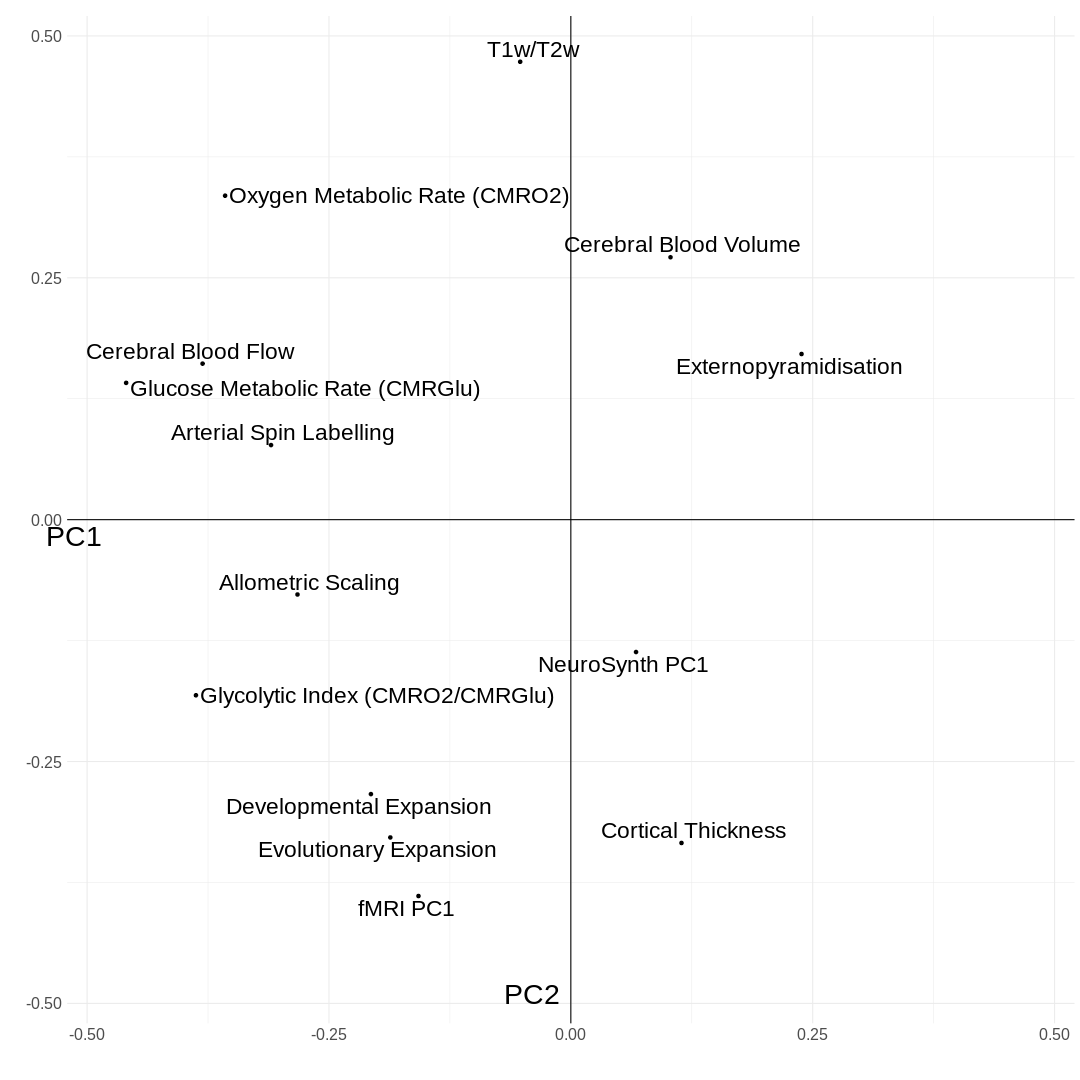

In [308]:
%%R -i pca_weights -w 15 -h 15 --units in
library(ggrepel)
plot_map_weights <- function(map_weights) {
    lim <- max(map_weights)

    map_weights %>%
    rownames_to_column('map') %>%
    ggplot(aes(G1, G2)) +
    geom_point() +
    geom_text_repel(aes(label=map), size=8) + 
    geom_vline(xintercept=0) + geom_hline(yintercept=0) +
    lims(x=c(-lim,lim), y=c(-lim,lim)) +
    coord_cartesian(clip='off') +
    labs(x='',y='') +
    annotate(geom='text', x=c(-lim, 0), y=c(0,-lim), label=c('PC1', 'PC2'), vjust=1.4, hjust=1.2, size=10) +
    theme_minimal() +
    theme(aspect.ratio=1,
          text=element_text(size=20)
         )
}
plot_map_weights(pca_weights)

In [311]:
both_scores = pd.concat({
    'MRI PCA':pca_scores * [-1,1,1], 
    'AHBA DM':ahba_scores.set_index('label')
}) \
.reset_index().rename({'level_0':'version'}, axis=1)

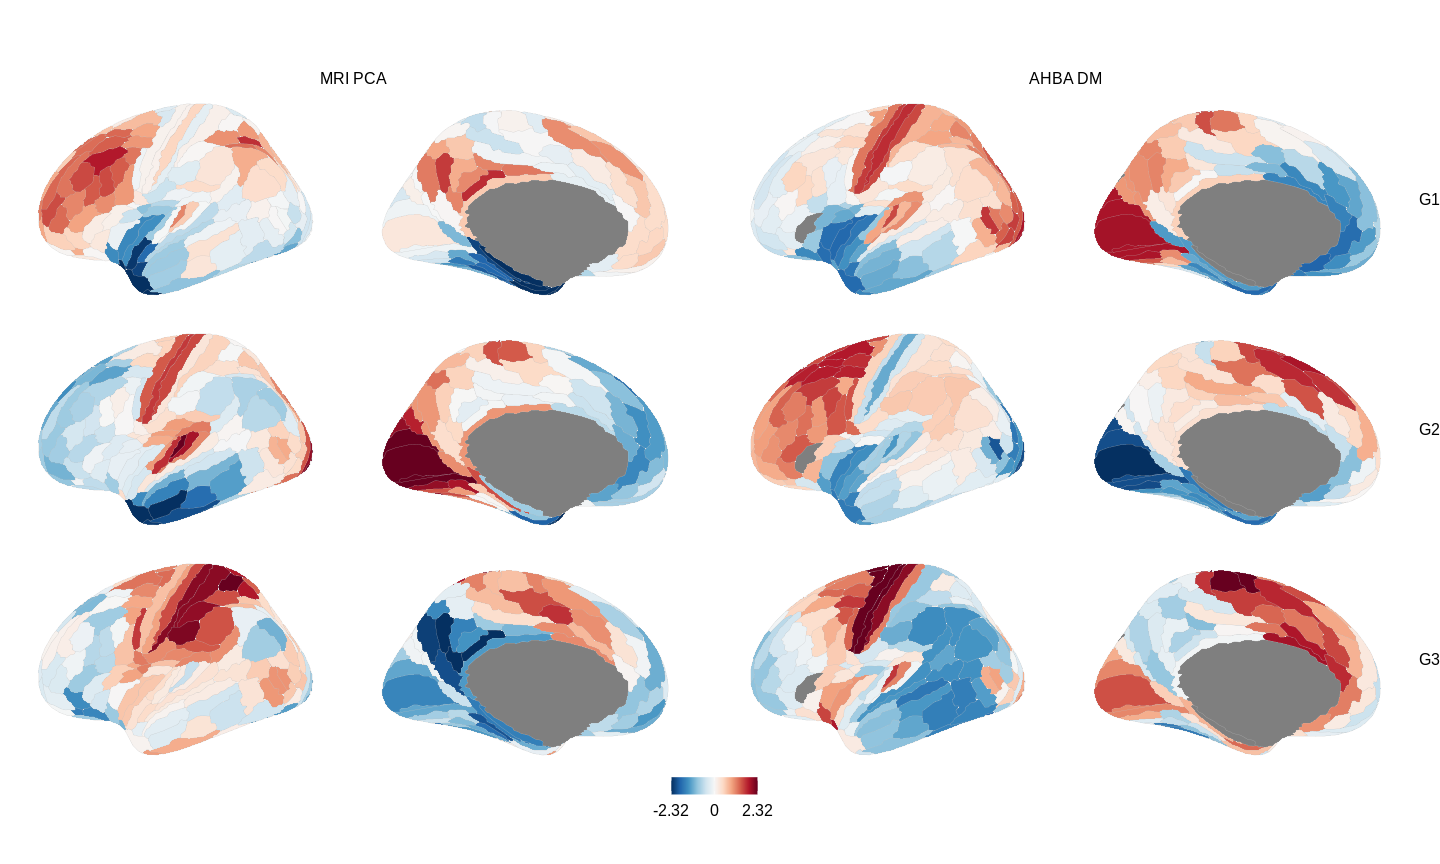

In [312]:
%%R -i both_scores -w 20 -h 12 --units in
plot_hcp(both_scores) & theme(text=element_text(size=20))

In [309]:
(correlate(ahba_scores.set_index('label'), pca_scores) 
 .style
 .set_table_styles([{
    'selector': 'tr',
    'props': [('background-color', '#ffffff'), ('color','black')]
}])
)

,G1,G2,G3
G1,-0.372875,0.678177,0.147100
G2,-0.643620,-0.340618,0.137454
G3,-0.036613,0.150315,0.171314


ICA

In [272]:
n = 100
ica_scores_reps = np.zeros([maps.shape[0], 3, n])
ica_weights_reps = np.zeros([maps.shape[1], 3, n])

ica_base = FastICA(n_components=3, random_state=5).fit(maps)
ica_base_scores = ica_base.transform(maps)
ica_base_weights = ica_base.components_.T
# ica_scores = pd.DataFrame(ica_base_scores,
#                           columns=['G1','G2','G3'], 
#                           index=maps.index) \
#             .apply(lambda x: (x-np.mean(x))/np.std(x))

# ica_weights = pd.DataFrame(ica_base_weights,
#                           columns=['G1','G2','G3'], 
#                           index=maps.columns) 

for i in range(n):
    ica_ = FastICA(n_components=3).fit(maps)
    ica_scores_ = ica.transform(maps)
    ica_weights_ = ica.components_.T
    corrs_ = np.corrcoef(x=ica_base_scores.T, y=ica_scores_.T)[:3,3:]
    matches_ = np.argmax(np.abs(corrs_), axis=1)
    signs_ = np.round(np.diag(corrs_[:,matches_]))
    
    ica_scores_reps[:,:,i] = ica_scores_[:, matches_] * signs_
    ica_weights_reps[:,:,i] = ica_weights_[:, matches_] * signs_
                       
ica_scores = pd.DataFrame(ica_scores_reps.mean(axis=2), 
                          columns=['G1','G2','G3'], 
                          index=maps.index) \
            .apply(lambda x: (x-np.mean(x))/np.std(x))

ica_weights = pd.DataFrame(ica_weights_reps.mean(axis=2),
                          columns=['G1','G2','G3'], 
                          index=maps.columns) 
            # .apply(lambda x: (x-np.mean(x))/np.std(x))

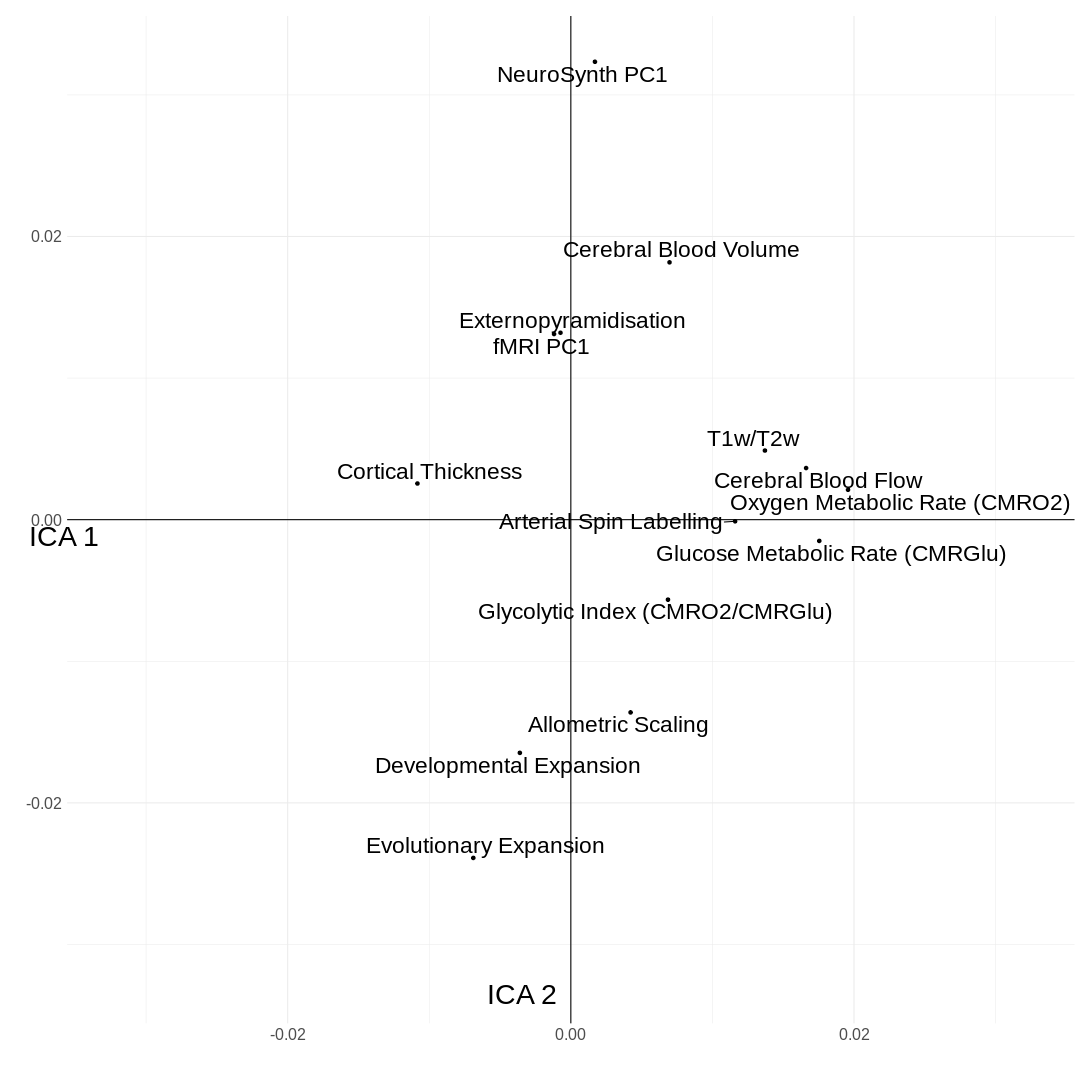

In [296]:
%%R -i ica_weights -w 15 -h 15 --units in
library(ggrepel)

plot_map_weights(ica_weights)

In [274]:
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
ahba_scores = dm_hcp_ds9.clean_scores() #.drop('G3', axis=1)

New gradients version: method=dm, kernel=normalized_angle, data=hcp_ds9


In [275]:
both_scores = pd.concat({
    'MRI ICA':ica_scores * [1,-1,-1], 
    'AHBA DM':ahba_scores.set_index('label')
}) \
.reset_index().rename({'level_0':'version'}, axis=1)

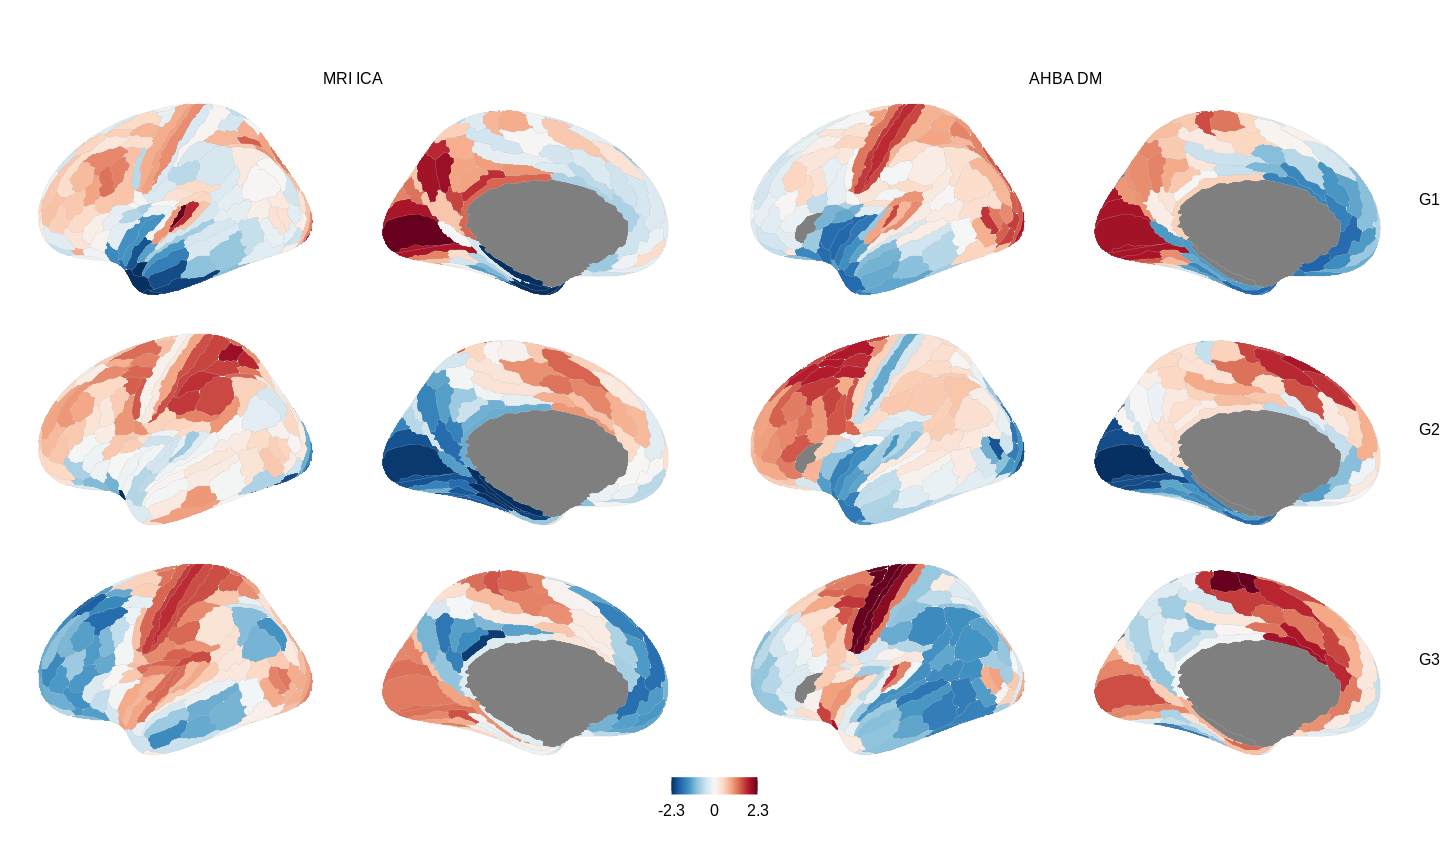

In [278]:
%%R -i both_scores -w 20 -h 12 --units in
plot_hcp(both_scores) & theme(text=element_text(size=20))

In [288]:
(correlate(ahba_scores.set_index('label'), ica_scores) 
 .style
 .set_table_styles([{
    'selector': 'tr',
    'props': [('background-color', '#ffffff'), ('color','black')]
}])
)

,G1,G2,G3
G1,0.686760,-0.055050,-0.388628
G2,0.243557,-0.538980,0.438340
G3,0.093134,-0.102712,-0.184645
